<a href="https://colab.research.google.com/github/marionwenger/DLColabNotebooks/blob/main/notebooks/15_faces_regression_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Regression with Tensorflow Probability

In this notebook you will learn how work with TFP. You will set up regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant and flexible standart deviation $\sigma$. The mean $\mu$ of the CPD will depend non-linearly on the input. You will compare the NLL of the two models with the constant and felxible standart deviation $\sigma$. As input data you will use images of faces and you will try to predict the conditional probability distribution of their age.

**Dataset:**
You work with a the UTKFace dataset. It is a large dataset with a large age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The data is already preprocessed and rescaled (80x80 pixels) so you can work with it. You will only use the information of the age and image.

**Content:**
* Load and and split the dataset
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a constant standart deviation $\sigma$ .
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a flexible standart deviation $\sigma$ with TFP.
* Compare the two models based on the NLL loss on the test dataset.


In [1]:
%tensorflow_version 2.x
# !pip install tensorflow==2.1.0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


#### Imports

In [2]:
import numpy as np
import urllib
import os
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
tfd = tfp.distributions


In [3]:
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.23.0
TF  Version 2.15.0


#### Loading the data, if it is not loaded

In [4]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")


In [5]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

#### Splitting the data into train, val and test dataset

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at the image data

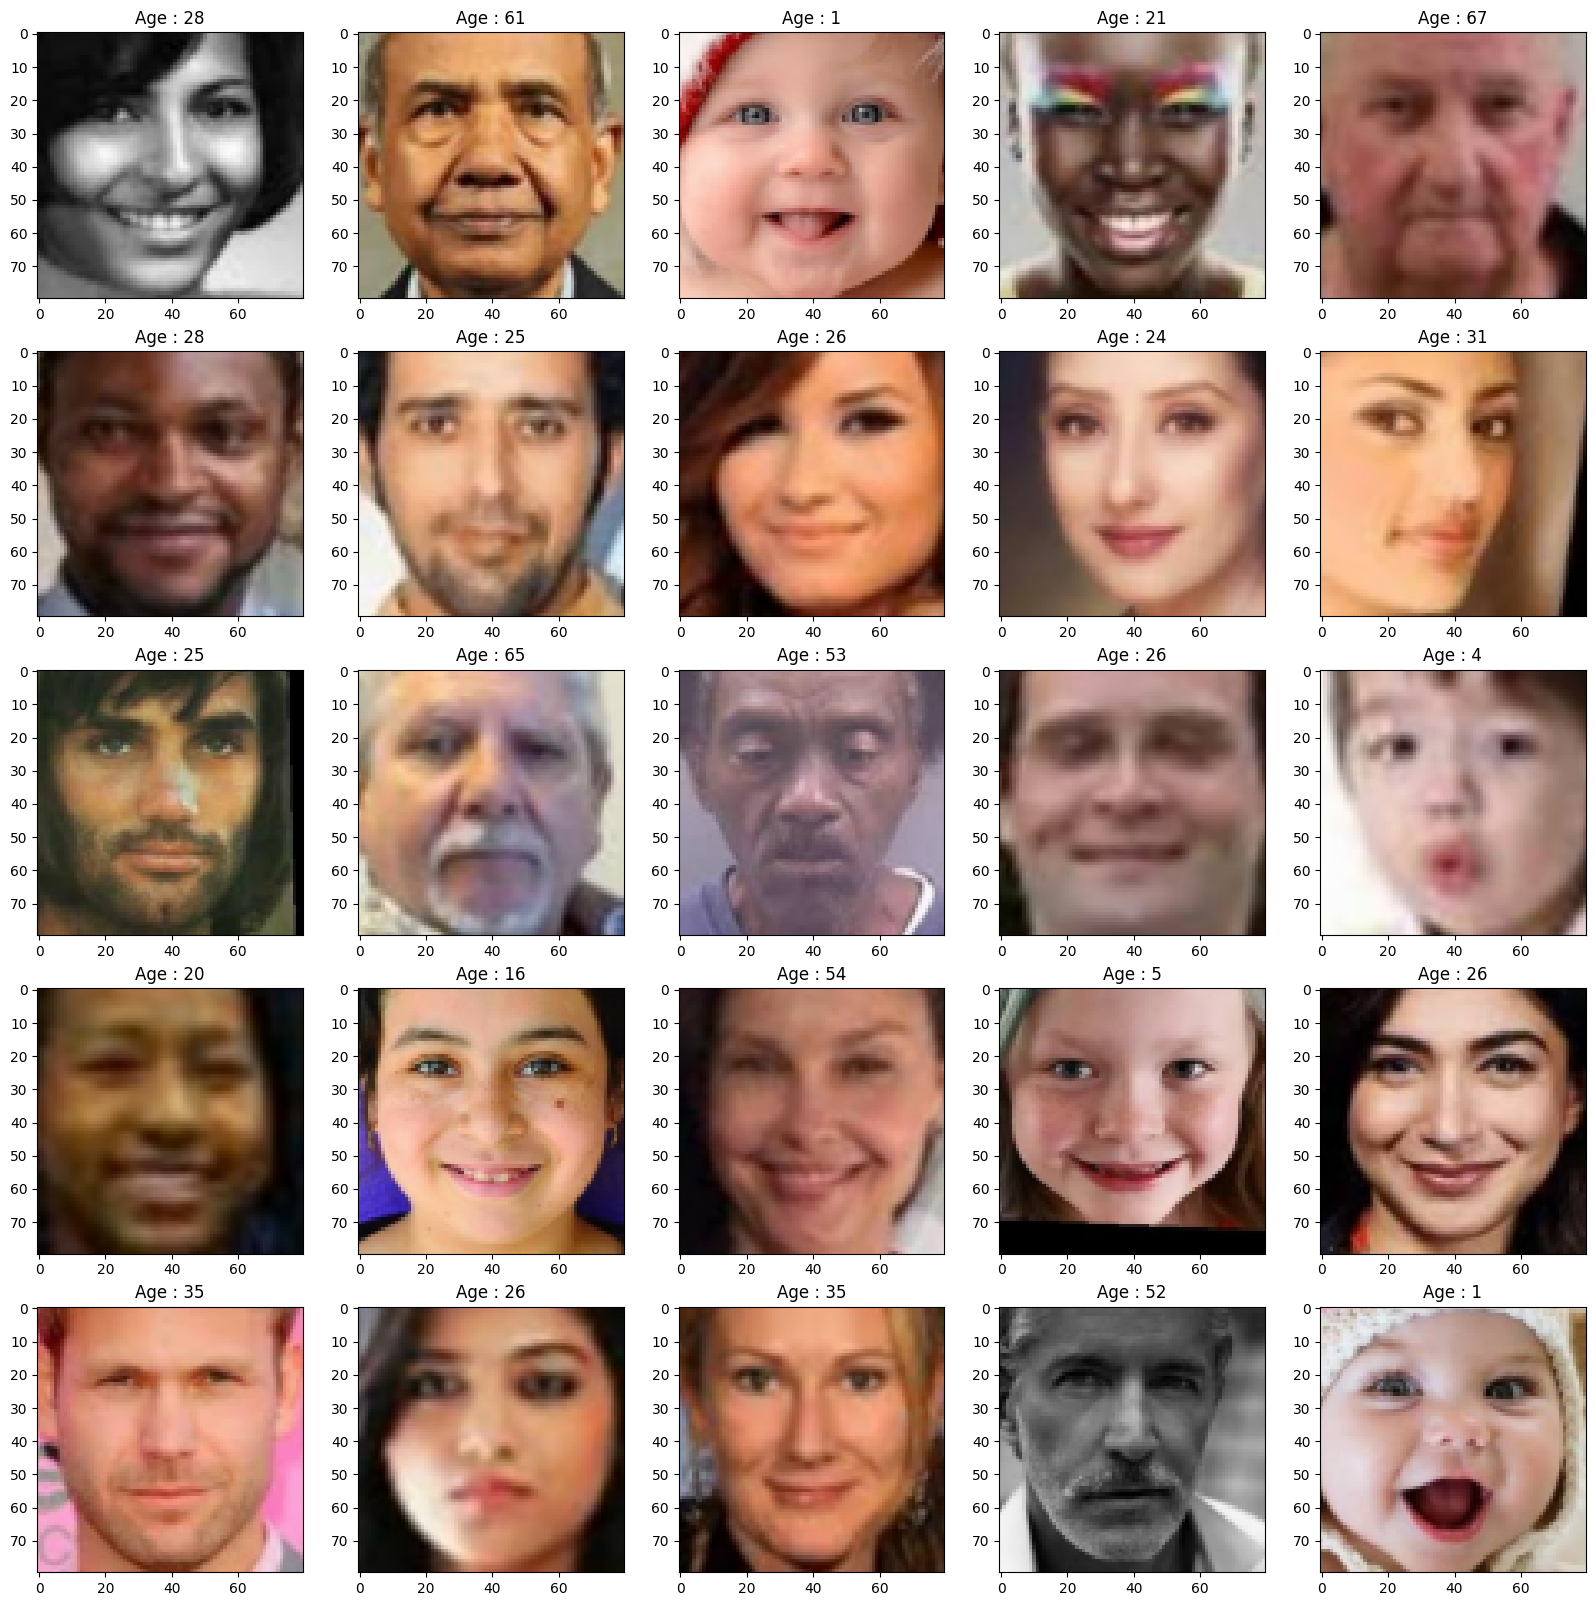

In [8]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ str(y_train[i]))

#### Normalize the data

In [9]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [10]:
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

y_train = np.array(y_train,dtype="float32")
y_val = np.array(y_val,dtype="float32")
y_test = np.array(y_test,dtype="float32")

#### Looking at the distribution of the target variable

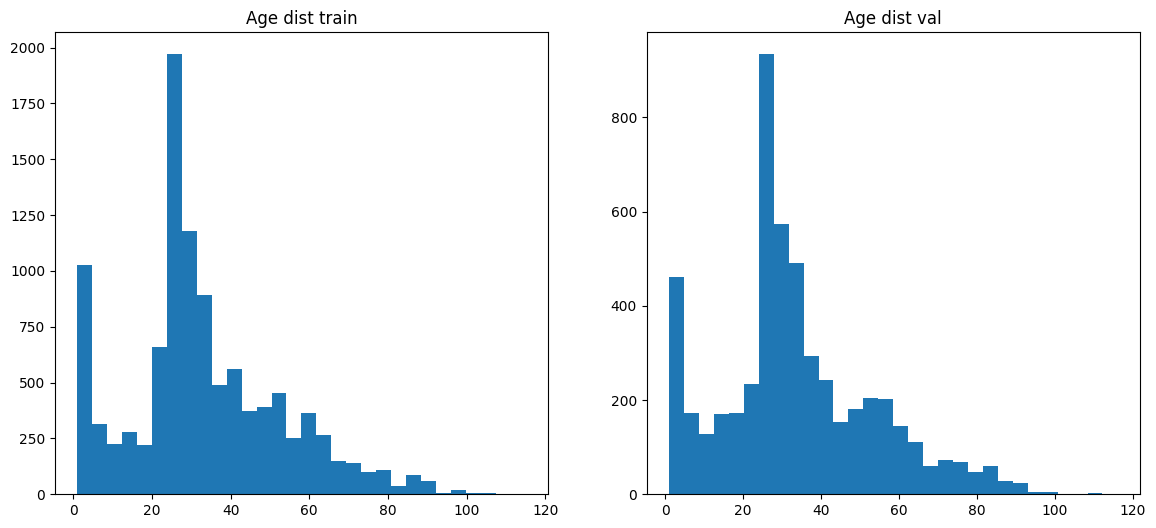

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(y_train,bins=30)
plt.title("Age dist train")
plt.subplot(1,2,2)
plt.hist(y_val,bins=30)
plt.title("Age dist val")
plt.show()


## Fit a regression model with constant variance
In the next cells you will define and fit a model on the face images. You will use a CNN to model the mu parameter of  a gaussian conditional probability distribution, the sigma will be constant for all inputs. For the loss we use the NLL. Note that we will use the trick with a second input that will be all ones, to model the constant sigma.

In [12]:
kernel_size = (3, 3)
pool_size = (2, 2)

In [13]:
def NLL(y, distr):
    return -distr.log_prob(y)

def my_dist(params):
    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

input1 = Input(shape=(80,80,3)) # techniches Hilfswerk, fake input, hilft hier, nix was man sich allgemein merken sollte
input2 = Input(shape=(1,))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
out1 = Dense(1)(x)
out2 = Dense(1)(input2)
params = Concatenate()([out1,out2])
dist = tfp.layers.DistributionLambda(my_dist)(params) #

model_const_sd = Model(inputs=[input1,input2], outputs=dist) ## use a trick with two inputs, input2 is just ones
model_const_sd.compile(tf.keras.optimizers.Adam(), loss=NLL)

In [14]:
# train the model
history=model_const_sd.fit([X_train, np.expand_dims(np.ones(len(X_train)),1)], y_train, # das ist ein hack
                    batch_size=16,
                    epochs=40,
                    verbose=1,
                    validation_data=([X_val,np.expand_dims(np.ones(len(X_val)),1)], y_val)
                  )


Epoch 1/40
666/666 [==============================] - 23s 15ms/step - loss: 431.5291 - val_loss: 353.9732
Epoch 2/40
666/666 [==============================] - 9s 13ms/step - loss: 278.7119 - val_loss: 204.9274
Epoch 3/40
666/666 [==============================] - 6s 9ms/step - loss: 179.1109 - val_loss: 185.3319
Epoch 4/40
666/666 [==============================] - 10s 15ms/step - loss: 142.6275 - val_loss: 100.9788
Epoch 5/40
666/666 [==============================] - 6s 9ms/step - loss: 115.9472 - val_loss: 124.1785
Epoch 6/40
666/666 [==============================] - 7s 10ms/step - loss: 98.6320 - val_loss: 98.6148
Epoch 7/40
666/666 [==============================] - 6s 9ms/step - loss: 87.7260 - val_loss: 75.7481
Epoch 8/40
666/666 [==============================] - 6s 9ms/step - loss: 78.2962 - val_loss: 67.5897
Epoch 9/40
666/666 [==============================] - 6s 9ms/step - loss: 67.5646 - val_loss: 71.9702
Epoch 10/40
666/666 [==============================] - 6s 9ms/step

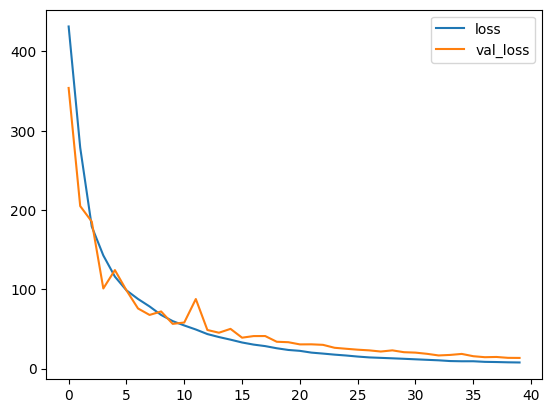

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


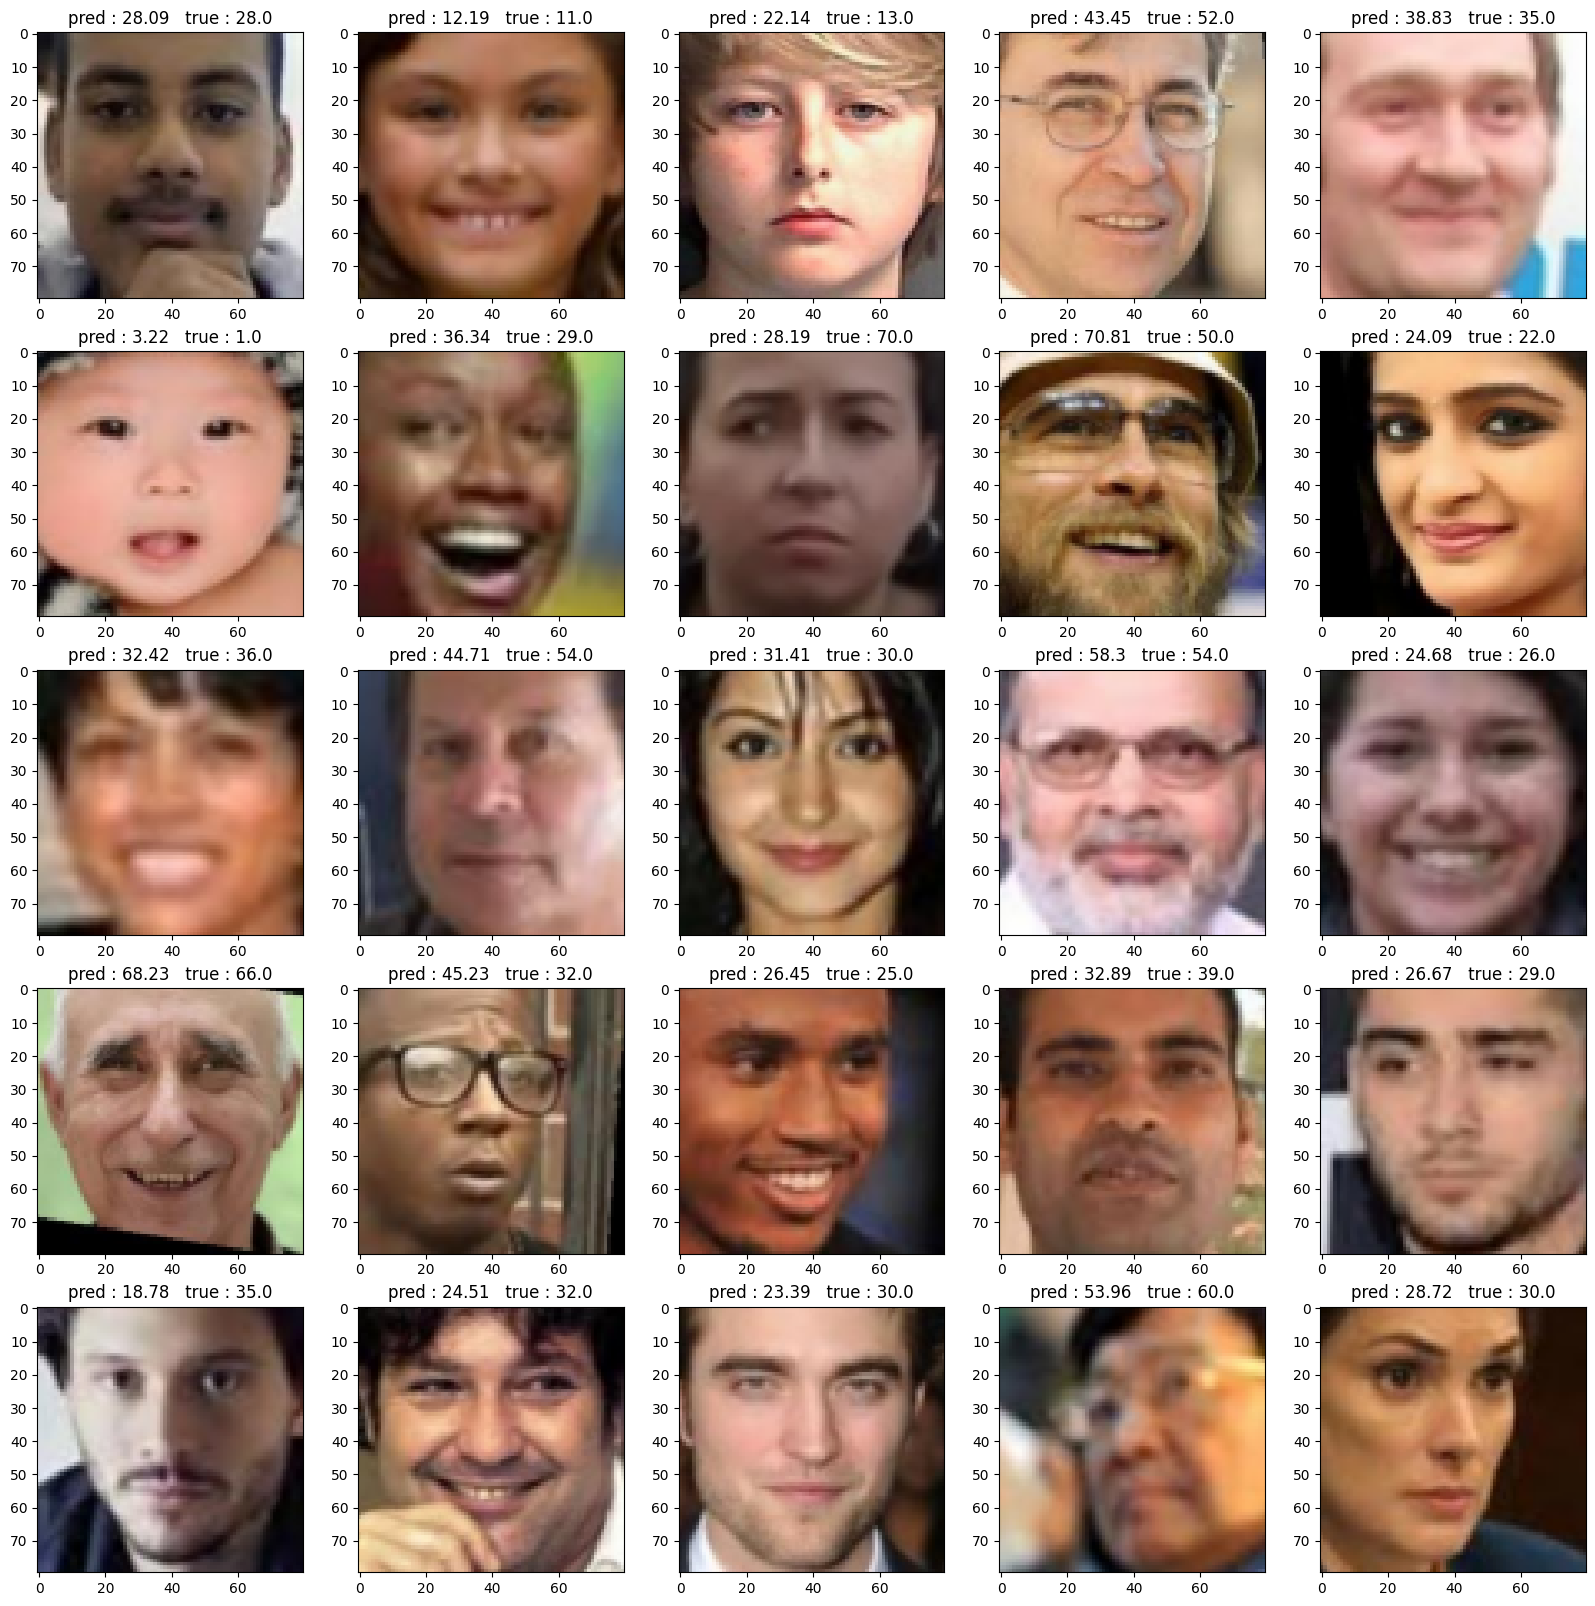

In [16]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+
              str(round(float(model_const_sd([X_test[i:i+1],
                                              np.expand_dims(np.ones(len(X_test[i:i+1])),1)]).mean()[0][0]), 2)) +
              "   true : "+ str(y_test[i]))

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


tf.Tensor([[28.093159]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.076192]], shape=(1, 1), dtype=float32)


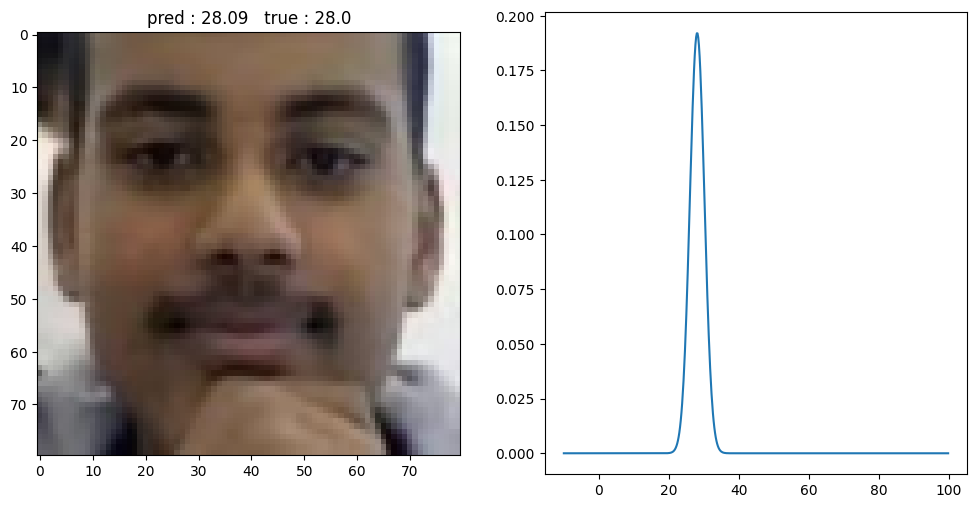

tf.Tensor([[12.188114]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.076192]], shape=(1, 1), dtype=float32)


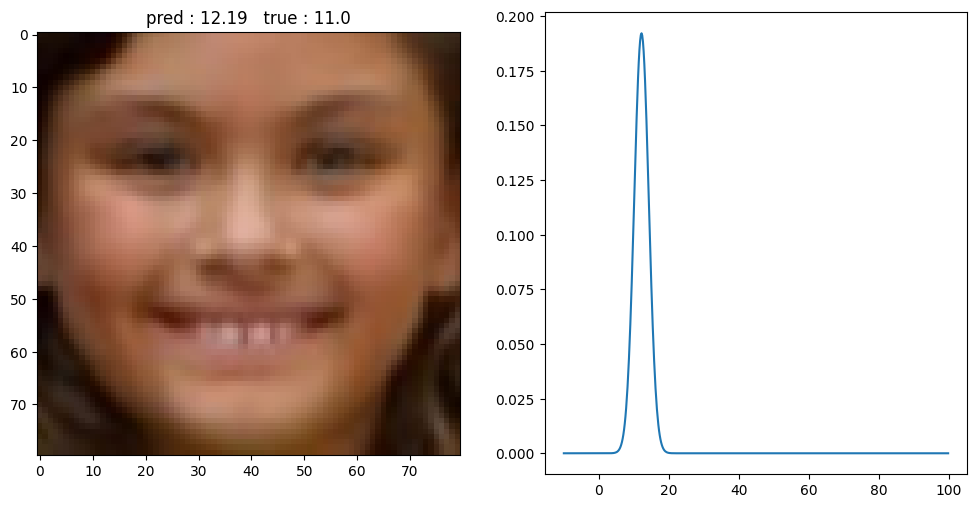

tf.Tensor([[22.142563]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.076192]], shape=(1, 1), dtype=float32)


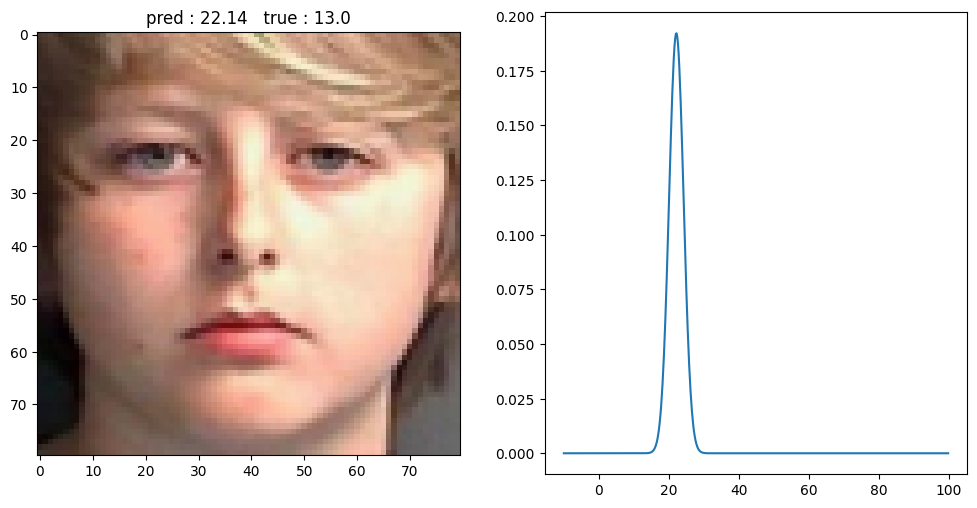

tf.Tensor([[43.45419]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.076192]], shape=(1, 1), dtype=float32)


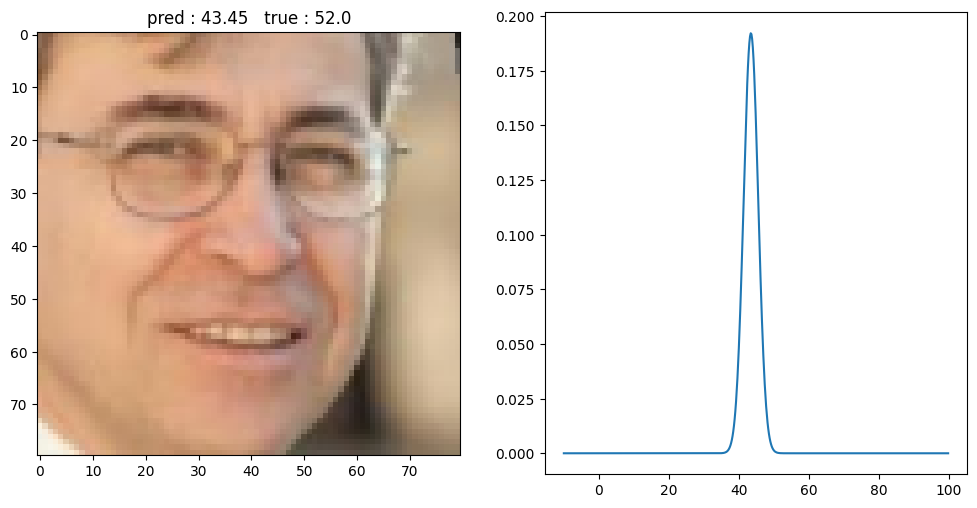

tf.Tensor([[38.830856]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.076192]], shape=(1, 1), dtype=float32)


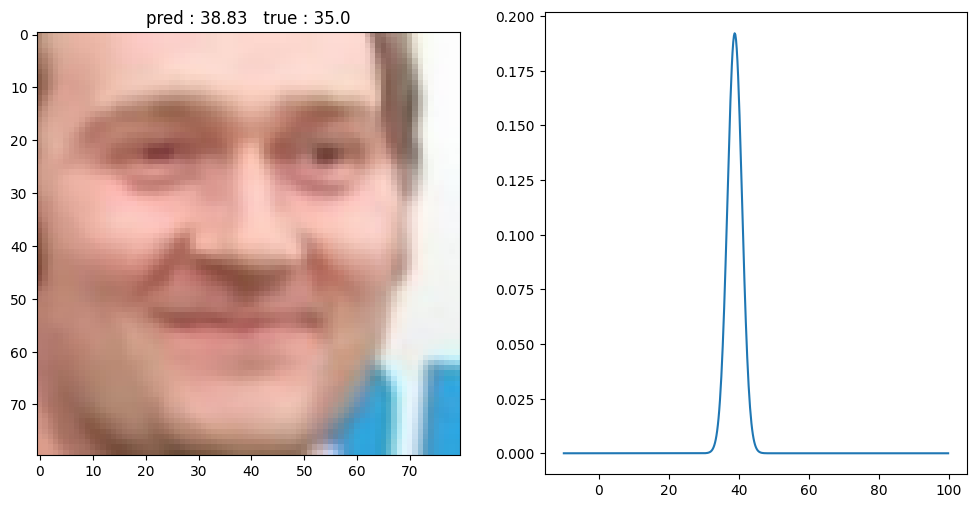

In [17]:
for i in range(0,5):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])

    mu = model_const_sd([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]).mean()
    sigma = model_const_sd([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]).stddev()
    print(mu)
    print(sigma)

    plt.title("pred : "+ str(round(float(mu), 2)) +
            "   true : "+ str(y_test[i]))
    d = tfd.Normal(loc=mu, scale=sigma)           #A
    plt.subplot(1,2,2)
    plt.plot(np.arange(-10,100,0.2),d.prob(np.arange(-10,100,0.2))[0])
    plt.show()

## Fit a regression model with felxible variance
In the next cells you will afain define and fit a model on the face images. You will use a CNN to model the mu parameter of a gaussian conditional probability distribution, but this time the sigma will not be constant for all inputs. Every iamge will be able to have a different sigma. For the loss we use the NLL.

In [18]:
def NLL(y, distr):
    return -distr.log_prob(y)

def my_dist(params):
    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

# hier braucht man den Trick von vorher nicht mehr, da flexible Varianz

inputs = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(inputs)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
dist = tfp.layers.DistributionLambda(my_dist)(x)

model_flex = Model(inputs=inputs, outputs=dist)
model_flex.compile(tf.keras.optimizers.Adam(), loss=NLL)


In [19]:
# train the model
history=model_flex.fit(X_train, np.array(y_train,dtype="float32"),
                  batch_size=16,
                  epochs=40,
                  verbose=1,
                  validation_data=(X_val, np.array(y_val,dtype="float32")))


Epoch 1/40
666/666 [==============================] - 10s 11ms/step - loss: 19.5680 - val_loss: 4.9121
Epoch 2/40
666/666 [==============================] - 6s 9ms/step - loss: 4.8087 - val_loss: 4.5268
Epoch 3/40
666/666 [==============================] - 6s 9ms/step - loss: 4.9593 - val_loss: 4.4586
Epoch 4/40
666/666 [==============================] - 6s 9ms/step - loss: 4.5991 - val_loss: 4.4229
Epoch 5/40
666/666 [==============================] - 6s 9ms/step - loss: 4.6157 - val_loss: 4.4680
Epoch 6/40
666/666 [==============================] - 6s 9ms/step - loss: 4.5734 - val_loss: 4.4882
Epoch 7/40
666/666 [==============================] - 6s 8ms/step - loss: 4.5390 - val_loss: 4.4337
Epoch 8/40
666/666 [==============================] - 6s 9ms/step - loss: 4.5062 - val_loss: 4.2942
Epoch 9/40
666/666 [==============================] - 6s 9ms/step - loss: 4.4129 - val_loss: 4.2644
Epoch 10/40
666/666 [==============================] - 6s 8ms/step - loss: 4.2806 - val_loss: 4.1

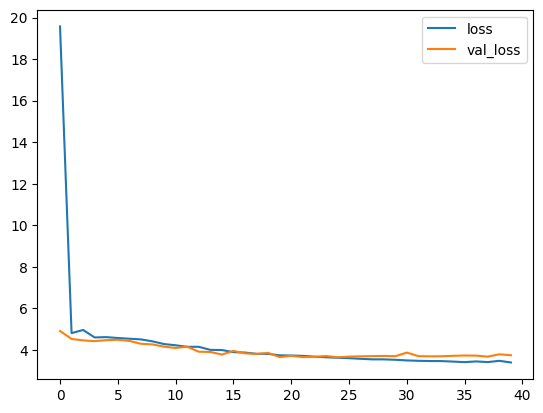

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


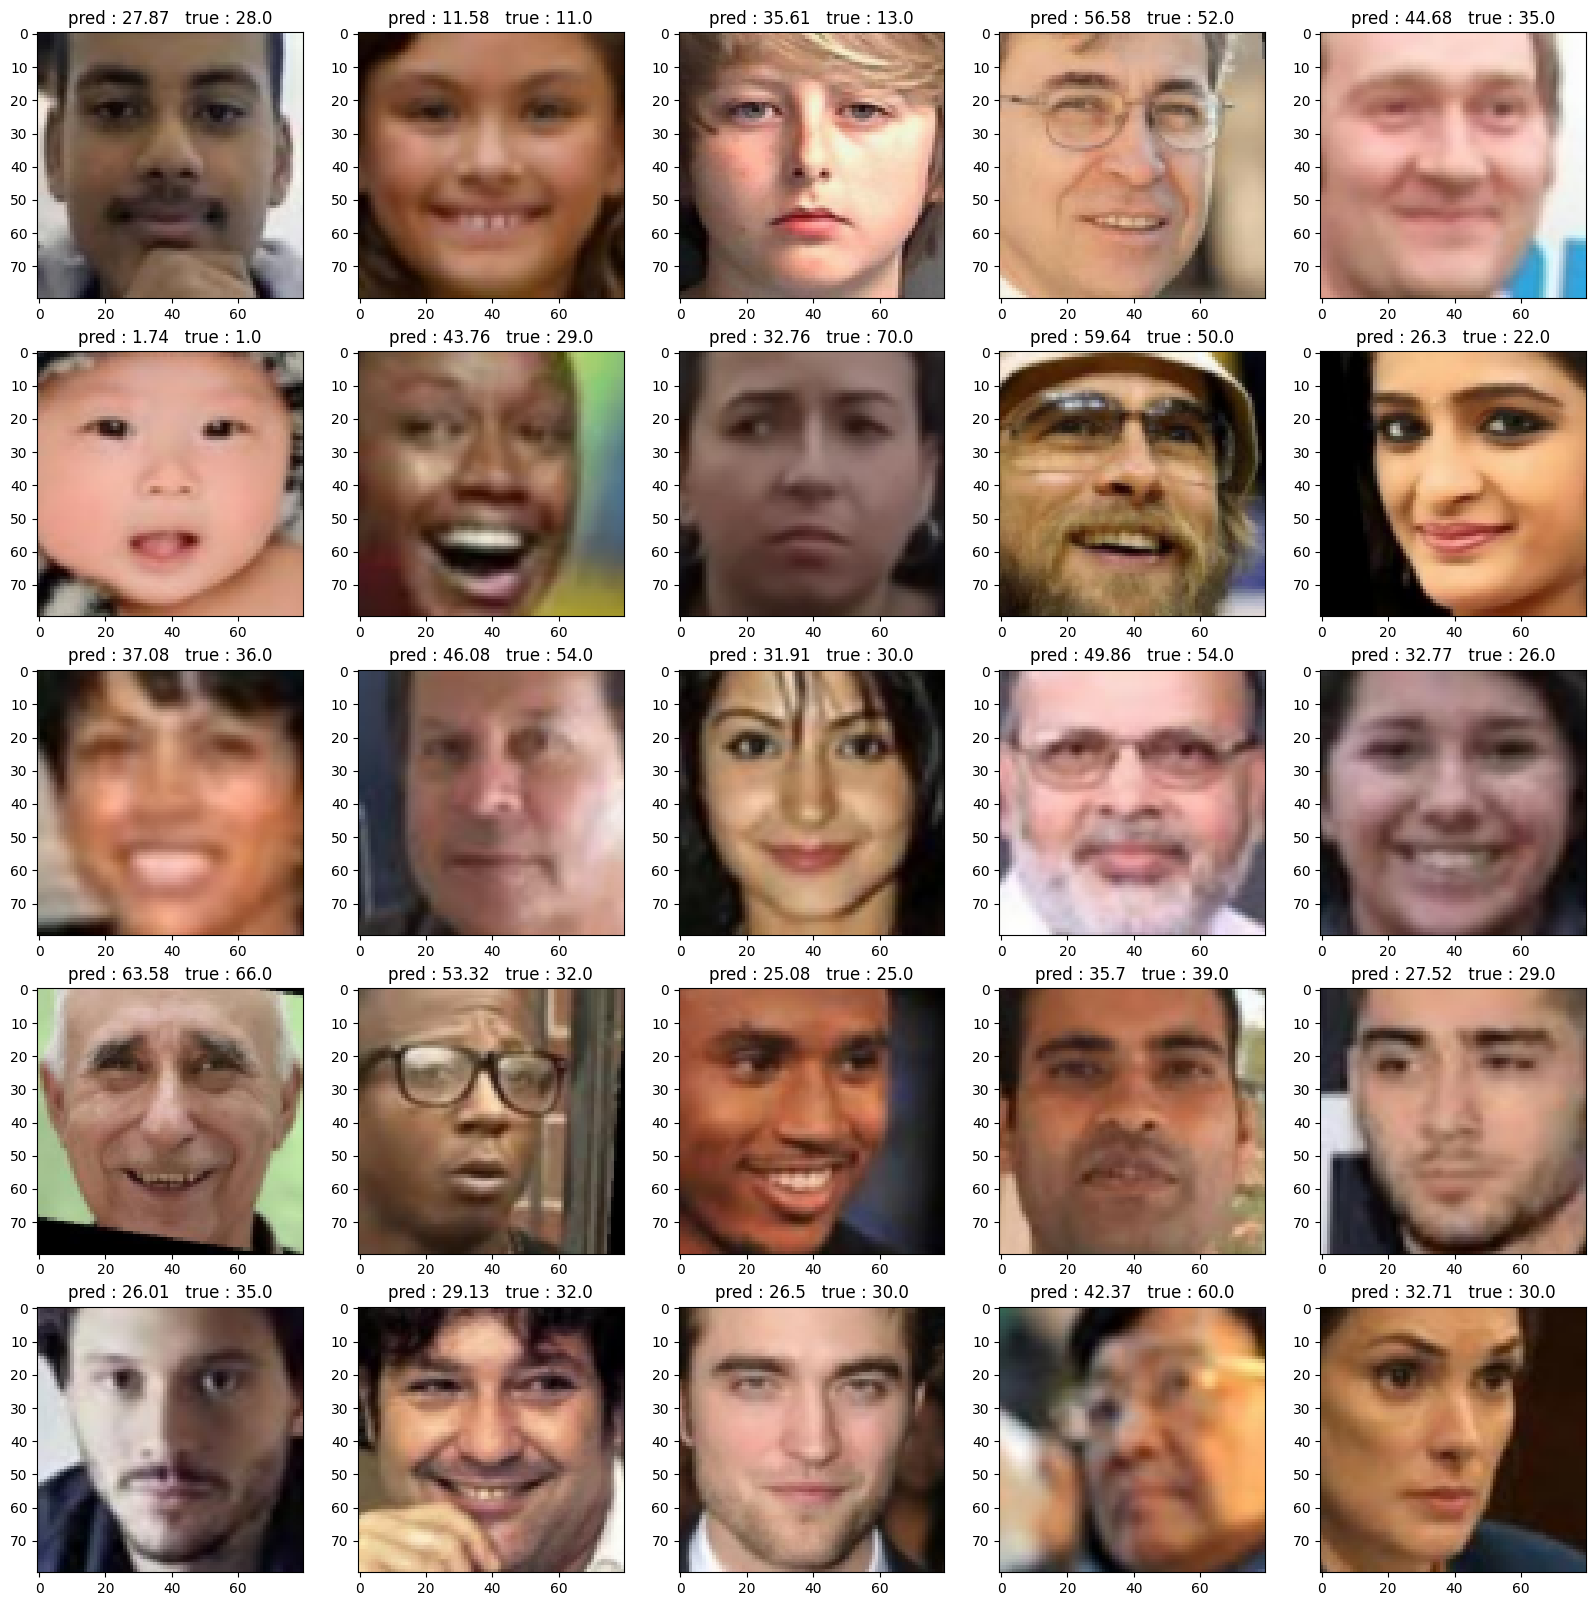

In [21]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ str(round(float(model_flex(X_test[i:i+1]).mean()[0][0]),2)) +
              "   true : "+ str(y_test[i]))

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


tf.Tensor([[27.86753]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.9611588]], shape=(1, 1), dtype=float32)


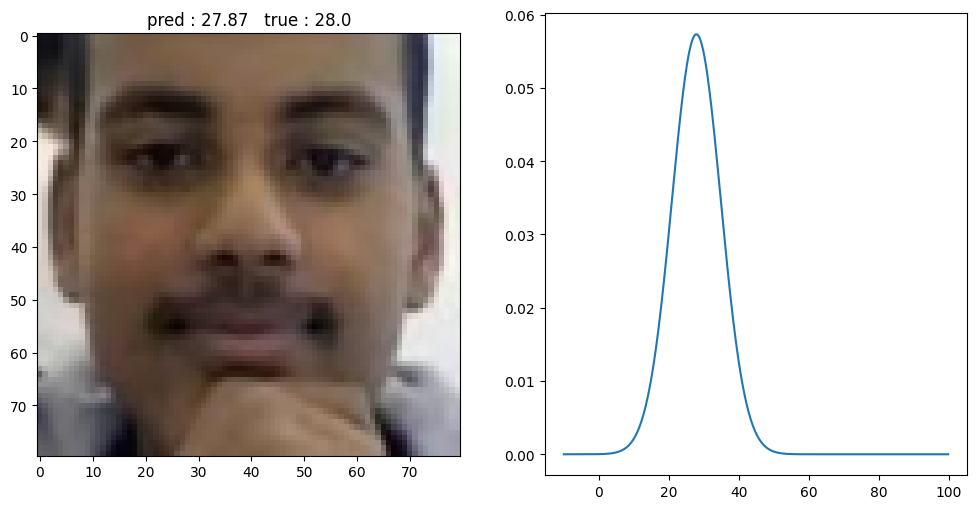

tf.Tensor([[11.581564]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.034535]], shape=(1, 1), dtype=float32)


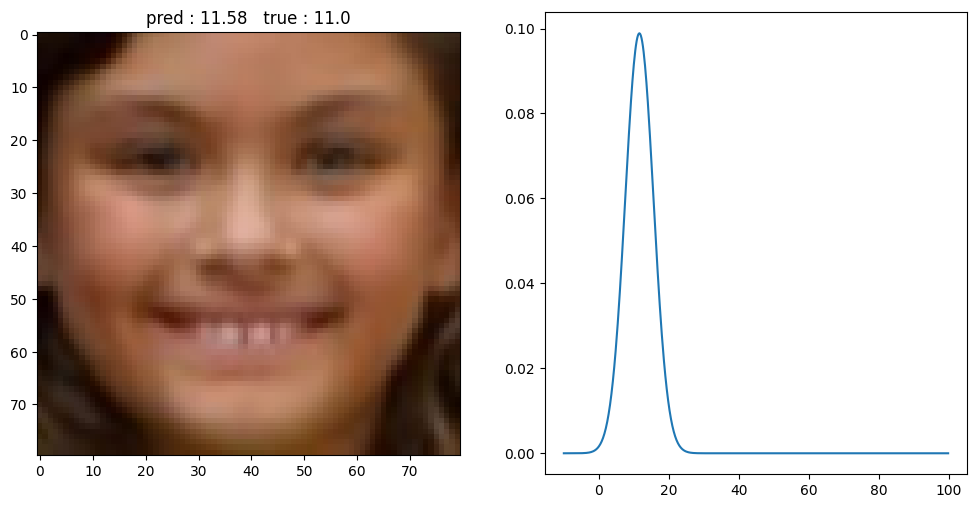

tf.Tensor([[35.61208]], shape=(1, 1), dtype=float32)
tf.Tensor([[10.444826]], shape=(1, 1), dtype=float32)


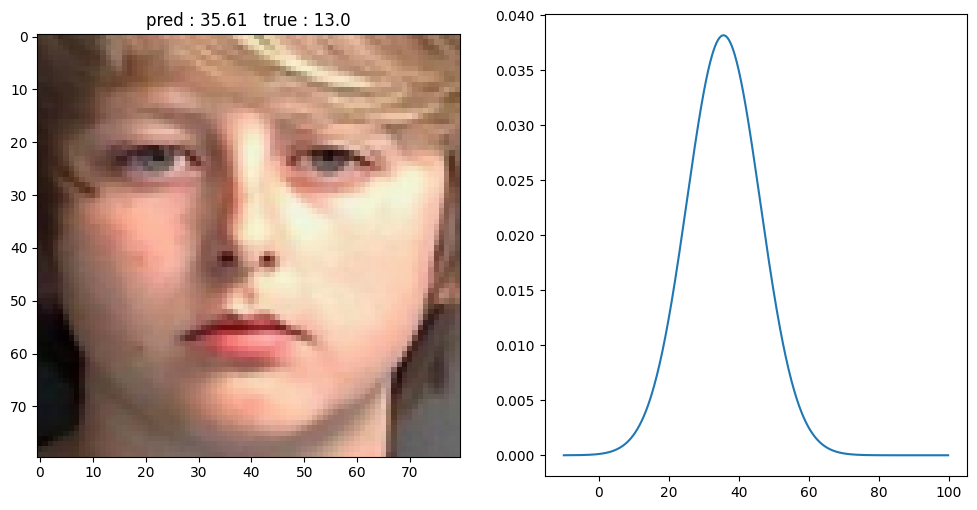

tf.Tensor([[56.576054]], shape=(1, 1), dtype=float32)
tf.Tensor([[15.972833]], shape=(1, 1), dtype=float32)


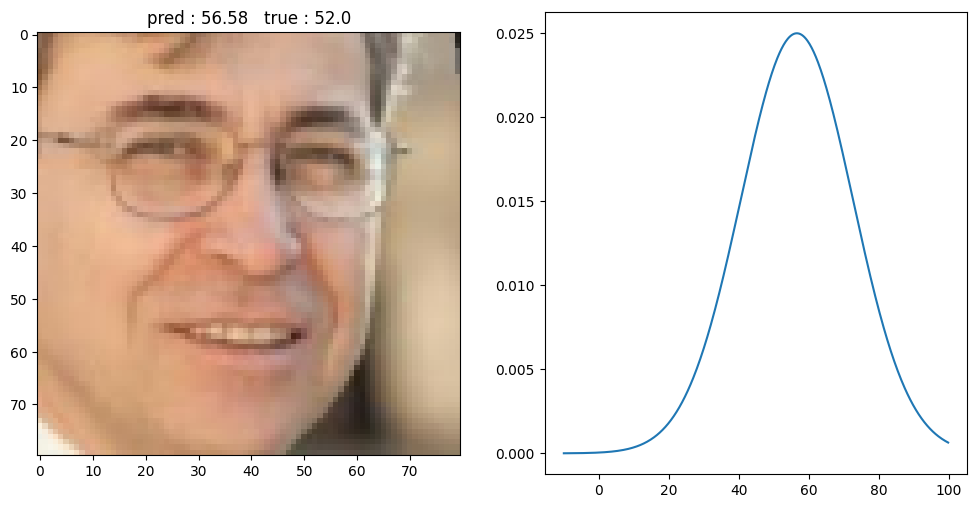

tf.Tensor([[44.676643]], shape=(1, 1), dtype=float32)
tf.Tensor([[12.357424]], shape=(1, 1), dtype=float32)


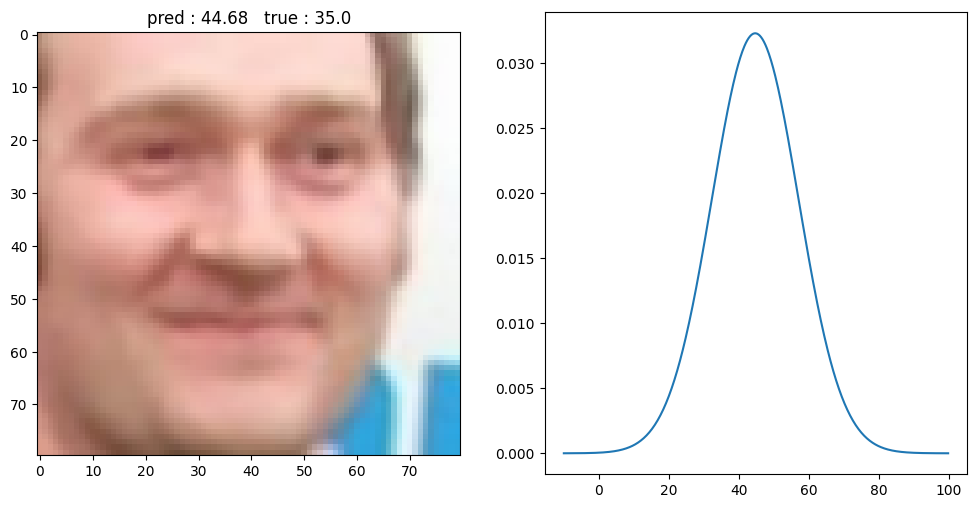

In [22]:
for i in range(0,5):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])

    mu = model_flex(X_test[i:i+1]).mean()
    sigma = model_flex(X_test[i:i+1]).stddev()
    print(mu)
    print(sigma)

    plt.title("pred : "+ str(round(float(mu),2)) + "   true : "+ str(y_test[i]))
    d = tfd.Normal(loc=mu, scale=sigma)           #A
    plt.subplot(1,2,2)
    plt.plot(np.arange(-10,100,0.2),d.prob(np.arange(-10,100,0.2))[0])
    plt.show()

#### Exercise
Calculate the MSE the RMSE and the NLL for both models on the testset.  
Which model would you prefer in practice and why?  



In [23]:
### Your code here

In [24]:
# prediction in while loop because else OOM error (Out Of Memory)

i = 0
mu1 = np.array([])
mu2 = np.array([])

while i <= len(X_test):
    if i+1000 > len(X_test):
        j = i + len(X_test)%1000
    else:
        j = i + 1000

    mu1 = np.append(mu1, model_const_sd([X_test[i:j], np.expand_dims(np.ones(len(X_test[i:j])),1)]).mean())
    mu2 = np.append(mu2, model_flex(X_test[i:j]).mean())

    i = j

In [25]:
mse_1 = np.average(np.square(mu1-y_test))
rmse_1 = np.sqrt(mse_1)
nll_1 = model_const_sd.evaluate([X_test,np.expand_dims(np.ones(len(X_test)),1)],y_test,verbose=0)

mse_2 = np.average(np.square(mu2-y_test))
rmse_2 = np.sqrt(mse_2)
nll_2 = model_flex.evaluate(X_test,y_test,verbose=0)

In [26]:
import pandas as pd
df1 = pd.DataFrame(
         { 'MSE' : mse_1, 'RMSE' : rmse_1, 'nll ' : nll_1}, index=['model const sigma'])
df2 = pd.DataFrame(
         { 'MSE' : mse_2, 'RMSE' : rmse_2, 'nll ' : nll_2}, index=['model flex sigma'])
pd.concat([df1,df2])

,MSE,RMSE,nll
model const sigma,101.318786,10.065723,13.401835
model flex sigma,122.288528,11.058414,3.695427
